In [1]:
import sys
sys.path.append('..')


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.getcwd()

'/home/borge/spiral_arms/George'

In [3]:
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['U','G','R','I','Z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [4]:
# Examine the outputs of the M51 B FICL run

# Original
M51_B_Original = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_B.fits')

# Isolated
M51_B_Isolated = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_B/0200/small_nonpar.fits')

M51_B_Table    = gfits.Read_Table('/home/borge/Data/Case_studies/M51/m51_optical_B/0200/source_params.fits')

log_n,log_re,mag,q,theta,x,y
float64,float64,float64,float64,float64,float64,float64
-0.36238123332758765,3.0692581521018023,-27.383377389043655,0.6518361992221887,-0.8744557214886713,-46.21234303728734,-449.93520783937834


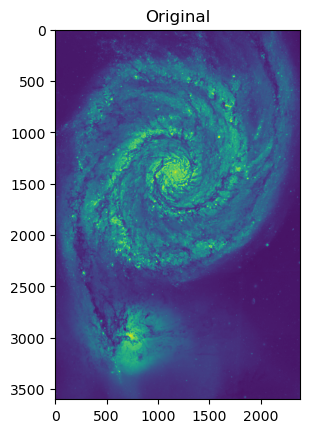

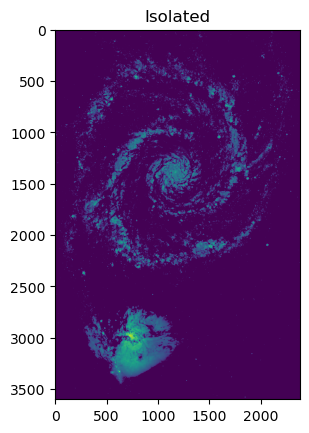

In [5]:
plt.figure()
plt.title('Original')
plt.imshow(M51_B_Original)

plt.figure()
plt.title('Isolated')
plt.imshow(M51_B_Isolated)

M51_B_Table

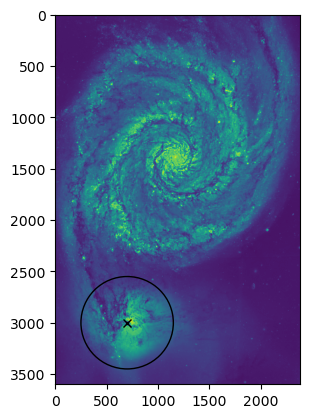

In [6]:
# Need to mask out M52
M52_pos = (700,3000)
M52_rad = 450
M52_mask_circle = plt.Circle(M52_pos,M52_rad,fill=None)

fig, ax = plt.subplots()
ax.imshow(M51_B_Original)
ax.plot(700,3000,'kx')
ax.add_patch(M52_mask_circle)

In [7]:
# Create mask for M51

# Create empty mask
M52_mask = np.empty_like(M51_B_Original)

for i in range(0,M51_B_Original.shape[0]):
    for j in range(0,M51_B_Original.shape[1]):
        if np.sqrt((i - M52_pos[1])**2 + (j - M52_pos[0])**2)< M52_rad:
            M52_mask[i,j] = 0
        else:
            M52_mask[i,j] = 1
            

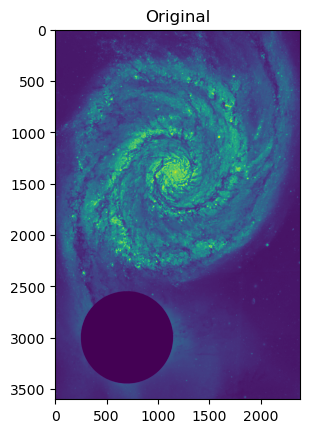

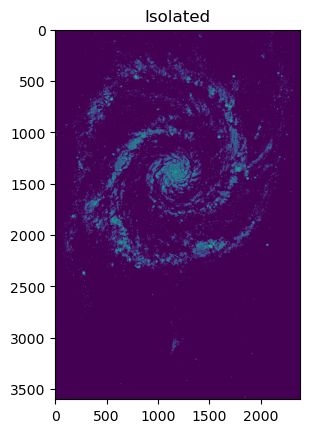

In [8]:
# Apply mask to image
M51_Original_no_M52 = M51_B_Original*M52_mask
M51_Isolated_no_M52 = M51_B_Isolated*M52_mask

# Examine images

plt.figure()
plt.title('Original')
plt.imshow(M51_Original_no_M52)

plt.figure()
plt.title('Isolated')
plt.imshow(M51_Isolated_no_M52)

# Export masked original

gfits.Write(M51_Original_no_M52,'M51_B_masked.fits')

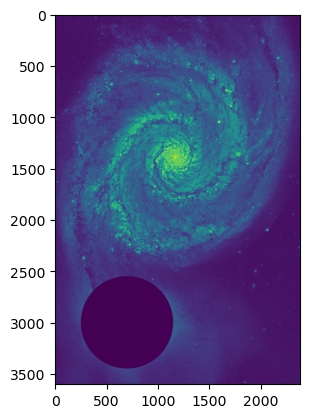

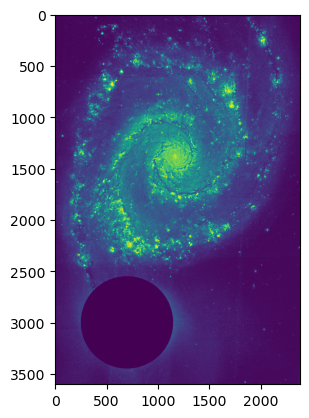

In [9]:
# Import G and R

M51_G_Original = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_G.fits')
M51_R_Original = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_R.fits')


M51_G_Original_no_M52 = M51_G_Original*M52_mask

M51_R_Original_no_M52 = M51_R_Original*M52_mask

plt.figure()
plt.imshow(M51_G_Original_no_M52)

plt.figure()
plt.imshow(M51_R_Original_no_M52)

#gfits.Write(M51_G_Original_no_M52,'M51_G_masked.fits')
#gfits.Write(M51_R_Original_no_M52,'M51_R_masked.fits')

In [10]:
# Apply SFT to the original and isolated M51 B

#m = gfits.Number_of_arms(M51_B_Isolated,M51_B_Table,0.3,True,False) 
m = 2

#phi, theta = gfits.Spiral_Fourier_Transform(M51_B_Isolated,M51_B_Table,2,0.3,True,False)

# Failing due to Either out of bounds or Big endian bullshit


Winding angle φ = 15.124007308311056  Pattern position angle θ =  10.1085833462779


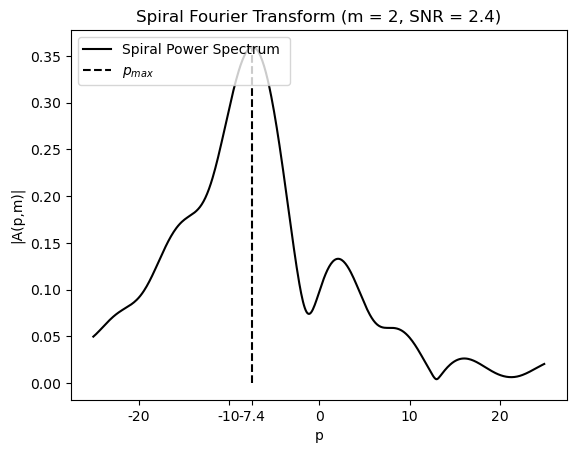

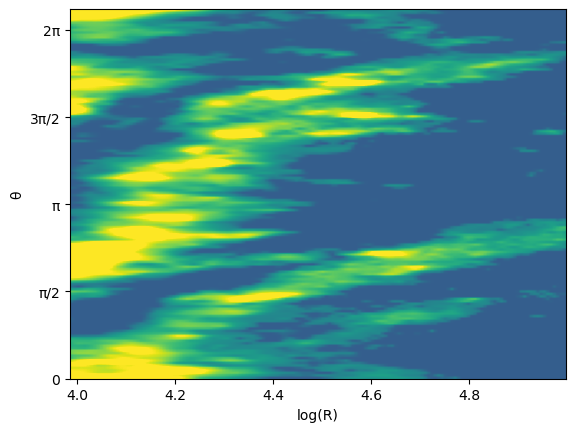

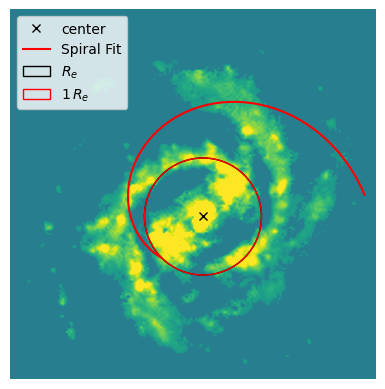

In [11]:
table, comp = gfits.Composite_from_directory_raid('587731892188545037','/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/')
phi, theta = gfits.Spiral_Fourier_Transform(comp[:,:,1],table[1],1,2,True,False)

# The function is working so there is something wrong with giving it a FAT image

In [12]:
img = M51_B_Isolated
Tab = M51_B_Table

R_min_multiple = 0.5

# First collect image info from Table
x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
log_R_e = np.asarray(Tab['log_re']) # log effective radius
log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
pa = np.asarray(Tab['theta']) # position angle
q = np.asarray(Tab['q']) # axis ratio

In [13]:
# Get the dimensions of the Image
height, width = img.shape[:2]   
height, width

(3600, 2384)

In [14]:
# Calculate the maximum possible radius
max_radius = min(x0, y0, width-x0, height-y0)
max_R = max_radius -1

max_R

array([[1144]])

In [15]:
# Create x and y index arrays
y, x = np.indices(img.shape)

# Center index arrays
x -= x0
y -= y0

x # Relative to the position

array([[-1145, -1144, -1143, ...,  1236,  1237,  1238],
       [-1145, -1144, -1143, ...,  1236,  1237,  1238],
       [-1145, -1144, -1143, ...,  1236,  1237,  1238],
       ...,
       [-1145, -1144, -1143, ...,  1236,  1237,  1238],
       [-1145, -1144, -1143, ...,  1236,  1237,  1238],
       [-1145, -1144, -1143, ...,  1236,  1237,  1238]])

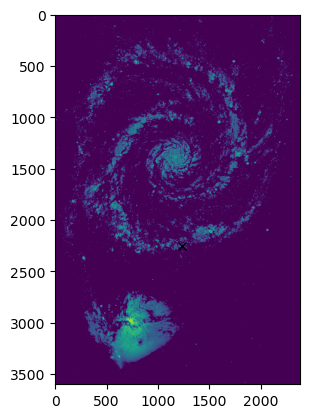

In [16]:
plt.figure()
plt.imshow(img)
plt.plot(img.shape[1]-x0,img.shape[0]-y0,'kx')

# The error could be due to the fact that M52 was not masked out before running

In [17]:
# Open Shivani's candidate list table

Candidate_list = gfits.Read_Table('/home/borge/spiral_arms/Shivani/candidates.fits')
len(Candidate_list)

109

In [18]:
# Get the candidate list from the table

Candidate_OBJIDs = np.asarray(Candidate_list['OBJID'])
np.savetxt('Final_candidate_list.txt',Candidate_OBJIDs,fmt='%d')
Candidate_list = np.loadtxt('Final_candidate_list.txt',dtype=str)


In [19]:
with open('Final_candidate_list_filenames.txt', "w") as f:
    for s in Candidate_list:
        f.write(s + "ua.fits.gz\n")
        f.write(s + "ga.fits.gz\n")
        f.write(s + "ra.fits.gz\n")
        f.write(s + "ia.fits.gz\n")
        f.write(s + "za.fits.gz\n")

In [20]:
# Done and on the server

# Open the 

# Original
M51_B_Original = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_B.fits')

# Isolated
M51_B_Isolated = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_B_masked/0200/small_nonpar.fits')
M51_B_Table    = gfits.Read_Table('/home/borge/Data/Case_studies/M51/m51_optical_B_masked/0200/source_params.fits')

log_n,log_re,mag,q,theta,x,y
float64,float64,float64,float64,float64,float64,float64
-0.6850369140371871,2.965835524808587,-27.06546720528241,0.7170852930766747,-0.6664022309896025,-18.880427370126927,-412.7547390895705


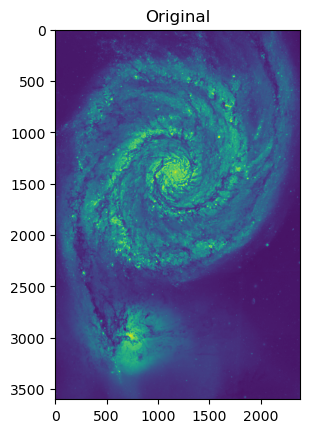

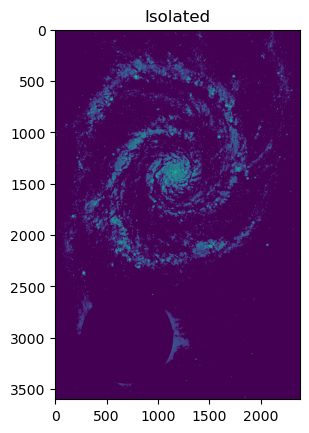

In [21]:
plt.figure()
plt.title('Original')
plt.imshow(M51_B_Original)

plt.figure()
plt.title('Isolated')
plt.imshow(M51_B_Isolated)

M51_B_Table

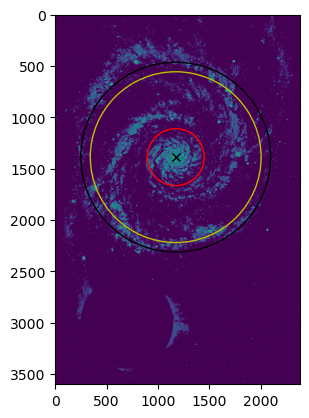

In [22]:
x0, y0 = M51_B_Table['x'], M51_B_Table['y']
Re = (10**M51_B_Table['log_re'])
n1 = 0.3
n2 = 0.9
Re_circle = plt.Circle((M51_B_Isolated.shape[1]/2+x0,M51_B_Isolated.shape[0]/2+y0),Re,fill=None)
Re_circle_n1 = plt.Circle((M51_B_Isolated.shape[1]/2+x0,M51_B_Isolated.shape[0]/2+y0),Re*n1,fill=None,color='r')
Re_circle_n2 = plt.Circle((M51_B_Isolated.shape[1]/2+x0,M51_B_Isolated.shape[0]/2+y0),Re*n2,fill=None,color='y')
fig, ax = plt.subplots()
ax.imshow(M51_B_Isolated)
ax.plot(M51_B_Isolated.shape[1]/2+x0,M51_B_Isolated.shape[0]/2+y0,'kx')
ax.add_patch(Re_circle)
ax.add_patch(Re_circle_n1)
ax.add_patch(Re_circle_n2)

In [23]:
# Run SFT on this
img = np.fliplr(M51_B_Isolated)
Tab = M51_B_Table

R_min_multiple = 0.5

# First collect image info from Table
x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
log_R_e = np.asarray(Tab['log_re']) # log effective radius
log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
pa = np.asarray(Tab['theta']) # position angle
q = np.asarray(Tab['q']) # axis ratio
# Get the dimensions of the Image
height, width = img.shape[:2]   
height, width
# Calculate the maximum possible radius
max_radius = min(x0, y0, width-x0, height-y0)
max_R = max_radius -1
# Create x and y index arrays
y, x = np.indices(img.shape)

# Center index arrays
x -= x0
y -= y0
# Deprojecting x,y by a series of affine transformations

# Rotate by minus position angle
ct = np.cos(-pa)
st = np.sin(-pa)

# Stretch according to axis ratio and rotation
xp = (y * ct + x * st) / q
yp = (-y * st + x * ct)

# Convert to Polar
rp2 = xp ** 2 +  yp ** 2
rp = np.sqrt(rp2)
tp = np.arctan2(yp, xp)

# Define ln(r),theta image dimensions
n_lnr = 150
n_theta = 150

# Create index arrays
lnr, theta = np.indices((n_lnr, n_theta))

# Define bounds for image dimensions
lnr_min = float(log_R_e_05)
lnr_max = float(np.log(int(max_R) -1))
theta_max = 360
lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
theta = theta * theta_max / n_theta

# Create yticks arrays
lnr_y_axis = np.linspace(lnr_min,lnr_max,5)

# Define xp and yp in terms of new coord system
xp = np.exp(lnr) * np.sin(np.radians(theta))
yp = np.exp(lnr) * np.cos(np.radians(theta))

# this is an attempt at using the above deprojection code
# to do the inverse by pa -> -pa and q -> 1/q   
ct = np.cos(pa)
st = np.sin(pa)
x = (yp * ct + xp * st) * q
y = (-yp * st + xp * ct)
x += y0
y += x0



In [24]:
# Create a Regular grid from interpolation

img = img.byteswap().newbyteorder('L')

img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])),img) # , bounds_error=False

In [25]:
# Define allowed indices
ok = (x >= 0) & (x < img.shape[0] - 1) 
ok &= (y >= 0) & (y < img.shape[1] - 1) 

In [26]:
# Create image from interpolation
img_lnr_theta = img_interp((x, y))

In [27]:
# Use broadcasting to do multiple p at once
p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
D = img_lnr_theta.sum()
A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
A_p_m = 1/D *(img_lnr_theta * weight).sum((-1, -2))

# Calculate winding angle from maximum of Spiral Power spectrum
p_max = p.ravel()[A.argmax()]
phi = np.degrees(np.arctan((0-m)/p_max))#

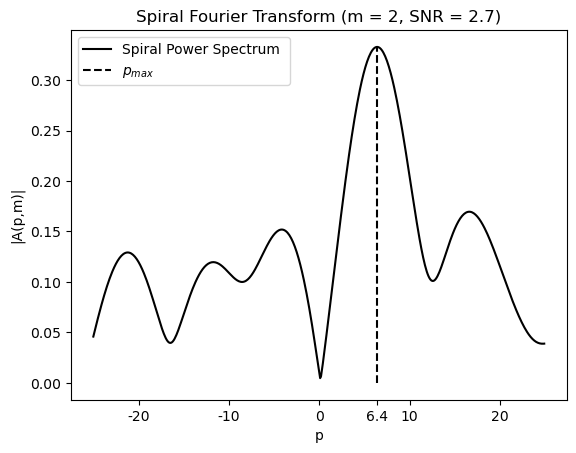

In [28]:
# Spiral Power Spectrum

SN_m, SN_w = gfits.SN(A_p_m)

plt.figure()
plt.plot(p.ravel(), A,'k')
plt.vlines(p_max,0,np.max(A),'k','dashed','$p_(max)$')
plt.legend(['Spiral Power Spectrum ','$p_{max}$'],loc='upper left')
plt.title('Spiral Fourier Transform (m = {}, SNR = {})'.format(m,np.around(SN_m,1)))
plt.xlabel('p')
plt.xticks([-20,-10,p_max,0,10,20],['-20','-10','{}'.format(np.around(p_max,1)),'0','10','20'])
plt.ylabel('|A(p,m)|');


([<matplotlib.axis.YTick at 0x7f8670ba5f00>,
 [Text(0, 0, '0'),
  Text(0, 900, 'π/2'),
  Text(0, 1800, 'π'),
  Text(0, 2700, '3π/2'),
  Text(0, 3600, '2π')])

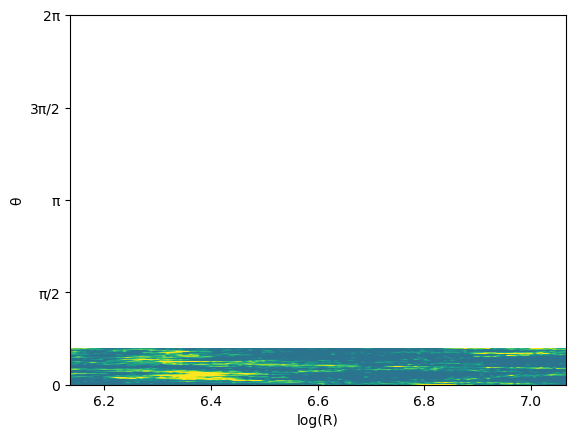

In [29]:
plt.figure()
plt.imshow(img_lnr_theta.T, vmin=np.mean(img_lnr_theta)-2*np.std(img_lnr_theta),
            vmax=np.mean(img_lnr_theta)+2*np.std(img_lnr_theta),
    extent=(lnr_min, lnr_max, 0, theta_max),
    origin='lower', aspect='auto');
plt.ylabel('\u03B8')
#plt.xticks([0,int(theta_max/4),int(theta_max/2),int(((theta_max)*3)/4),theta_max],['0','\u03C0/2','\u03C0','3\u03C0/2','2\u03C0'])  # come back
plt.xlabel('log(R)')
plt.yticks([0,int(img.shape[0]/4),int(img.shape[0]/2),int(((img.shape[0])*3)/4),img.shape[0]],['0','\u03C0/2','\u03C0','3\u03C0/2','2\u03C0'])


Winding angle φ = 19.33480853782727  Pattern position angle θ =  4.594468631582372


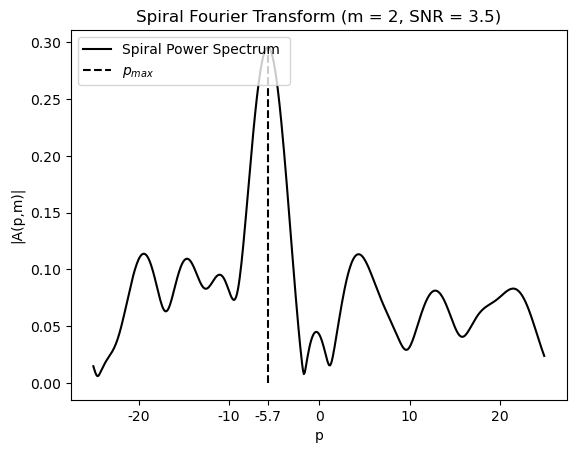

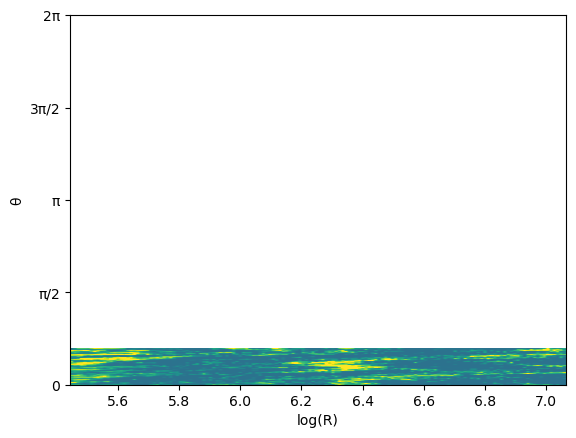

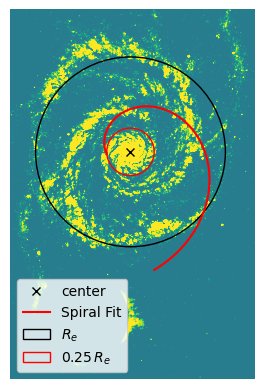

In [30]:
# Maybe fixing the byte order fixes it going to add an input as a kwarg for if
# this needs to be done
phi, argument = gfits.Spiral_Fourier_Transform(M51_B_Isolated,M51_B_Table,0.25,2,True,False,byte_order=True)


Winding angle φ = 24.943905263426075  Pattern position angle θ =  -5.232577516759097


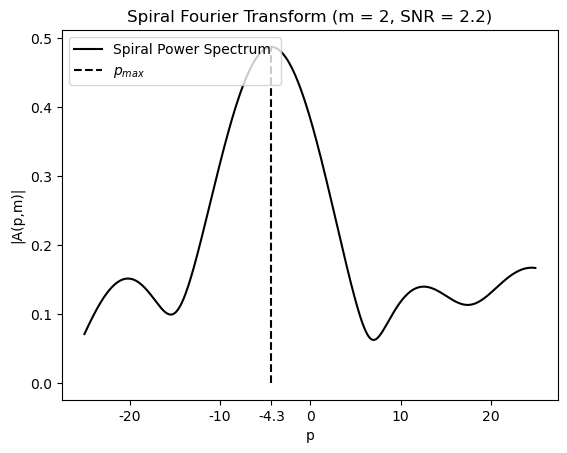

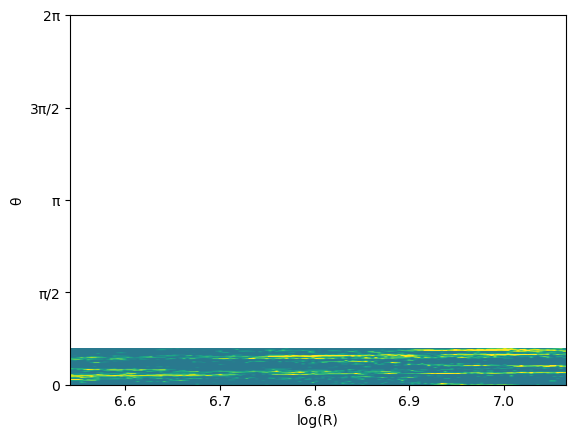

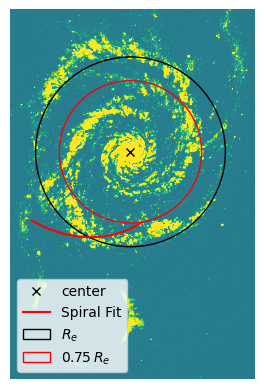

In [31]:
phi, argument = gfits.Spiral_Fourier_Transform(M51_B_Isolated,M51_B_Table,0.75,2,True,False,byte_order=True)


In [32]:
A, A_p_m, p, SN_w, p_max, SN_m, phi = gfits.Spiral_power_spec(M51_B_Isolated,M51_B_Table,0.2,2,byte_order=True)

In [33]:
def Spiral_Fourier_Transform(Image,Table,n1,n2,m,plot,save,byte_order=False):
    """A function to calculate the Spiral Fourier Transform and the winding angle of a given image.

    Args:
    Image (numpy.ndarray): A 2D numpy array representing the input image.
    Table (astropy.Table): A table containing the coordinates and parameters of the object to be analyzed.
    R_min_multiple (float): The multiple of the effective radius at which the minimum radius is set.
    m (int): The order of the Fourier mode.
    plot (bool): A boolean indicating whether or not to plot the results.
    save (bool): A boolean indicating whether or not to save the plot.

    Returns:
    phi (float): The winding angle in degrees.
    """
    
    img = Image
    Tab = Table
    # First collect image info from Table
    x0 = np.array([img.shape[1]/2 + np.asarray(Tab['x'])]).astype(int) # x offset
    y0 = np.array([img.shape[0]/2 + np.asarray(Tab['y'])]).astype(int) # y offset
    R_e = 10**(np.asarray(Tab['log_re'])) # effective radius in pix
    #log_R_e = np.asarray(Tab['log_re']) # log effective radius
    #log_R_e_05 = np.log(10**np.asarray(Tab['log_re'])*R_min_multiple) # log half effective radius
    pa = np.asarray(Tab['theta']) # position angle
    q = np.asarray(Tab['q']) # axis ratio
    
    
    # Get the dimensions of the Image
    height, width = img.shape[:2]   

    # Calculate the maximum possible radius
    max_radius = min(x0, y0, width-x0, height-y0)
    max_R = R_e*n2#max_radius -1
    
    # Create x and y index arrays
    y, x = np.indices(img.shape)
    
    # Center index arrays
    x -= x0
    y -= y0
    
    # Deprojecting x,y by a series of affine transformations

    # Rotate by minus position angle
    ct = np.cos(-pa)
    st = np.sin(-pa)

    # Stretch according to axis ratio and rotation
    xp = (y * ct + x * st) / q
    yp = (-y * st + x * ct)

    # Convert to Polar
    rp2 = xp ** 2 +  yp ** 2
    rp = np.sqrt(rp2)
    tp = np.arctan2(yp, xp)
    
    # Define ln(r),theta image dimensions
    n_lnr = 150
    n_theta = 150
    
    # Create index arrays
    lnr, theta = np.indices((n_lnr, n_theta))
    
    # Define bounds for image dimensions
    lnr_min = float(np.log(n1*R_e))
    lnr_max = float(np.log(n2*R_e))  # float(np.log(int(max_R) -1))
    theta_max = 360
    lnr = (lnr / n_lnr) * (lnr_max - lnr_min) + lnr_min
    theta = theta * theta_max / n_theta
    
    # Create yticks arrays
    lnr_y_axis = np.linspace(lnr_min,lnr_max,5)
    
    # Define xp and yp in terms of new coord system
    xp = np.exp(lnr) * np.sin(np.radians(theta))
    yp = np.exp(lnr) * np.cos(np.radians(theta))
    
    # this is an attempt at using the above deprojection code
    # to do the inverse by pa -> -pa and q -> 1/q   
    ct = np.cos(pa)
    st = np.sin(pa)
    x = (yp * ct + xp * st) * q
    y = (-yp * st + xp * ct)
    x += y0
    y += x0
    
    if byte_order == True:
        img = img.byteswap().newbyteorder('L')
    else:
        img = img
    
    # Create a Regular grid from interpolation
    img_interp = RegularGridInterpolator((np.arange(img.shape[0]),
                                          np.arange(img.shape[1])),img, bounds_error=False)
    
    # Define allowed indices
    ok = (x >= 0) & (x < img.shape[0] - 1) 
    ok &= (y >= 0) & (y < img.shape[1] - 1) 
    
    # Create image from interpolation
    img_lnr_theta = img_interp((x, y))
    
    # Use broadcasting to do multiple p at once
    p = np.arange(-25, 25, 0.1).reshape((-1, 1, 1))
    weight = np.exp(1j*(m * np.radians(theta) + lnr * p))
    D = img_lnr_theta.sum()
    A = 1/D * abs((img_lnr_theta * weight).sum((-1, -2)))
    A_p_m = 1/D *(img_lnr_theta * weight).sum((-1, -2))
    
    # Calculate winding angle from maximum of Spiral Power spectrum
    p_max = p.ravel()[A.argmax()]
    phi = np.degrees(np.arctan((0-m)/p_max))#
    
    # Generate spiral for plotting
    x_,y_, argument = gfits.gen_spiral(p_max,A_p_m,m,R_e,R_min_multiple,img,x0[0],y0[0])
    
    if 88<phi<92 or -88>phi>-92:
        print('Winding angle \u03C6 =',None,'- No pattern identified')
    else:
        print('Winding angle \u03C6 =', phi,' Pattern position angle \u03B8 = ',np.degrees(argument))
        
    
    
    # Calculate signal to Noise
    SN_m, SN_w = gfits.SN(A_p_m)

    if plot == True:
        
        # Spiral Power Spectrum
        plt.figure()
        plt.plot(p.ravel(), A,'k')
        plt.vlines(p_max,0,np.max(A),'k','dashed','$p_(max)$')
        plt.legend(['Spiral Power Spectrum ','$p_{max}$'],loc='upper left')
        plt.title('Spiral Fourier Transform (m = {}, SNR = {})'.format(m,np.around(SN_m,1)))
        plt.xlabel('p')
        plt.xticks([-20,-10,p_max,0,10,20],['-20','-10','{}'.format(np.around(p_max,1)),'0','10','20'])
        plt.ylabel('|A(p,m)|');
        if save == True:
            plt.savefig('Power Spectrum.png')
        
        # ln(r) theta imageS
        plt.figure()
        plt.imshow(img_lnr_theta.T, vmin=np.mean(img_lnr_theta)-2*np.std(img_lnr_theta),
                   vmax=np.mean(img_lnr_theta)+2*np.std(img_lnr_theta),
           extent=(lnr_min, lnr_max, 0, theta_max),
           origin='lower', aspect='auto');
        plt.ylabel('\u03B8')
        #plt.xticks([0,int(theta_max/4),int(theta_max/2),int(((theta_max)*3)/4),theta_max],['0','\u03C0/2','\u03C0','3\u03C0/2','2\u03C0'])  # come back
        plt.xlabel('log(R)')
        plt.yticks([0,int(img.shape[0]/4),int(img.shape[0]/2),int(((img.shape[0])*3)/4),img.shape[0]],['0','\u03C0/2','\u03C0','3\u03C0/2','2\u03C0'])
        if save == True:
            plt.savefig('log(R) Theta image.png')
        
        # Labeled galaxy Image
        fig, ax = plt.subplots()
        ax.imshow(img,vmin=np.mean(img)-2*np.std(img),vmax=np.mean(img)+2*np.std(img))

        # Define circle
        R_e_1 = plt.Circle((x0,y0),R_e,edgecolor='black', facecolor=None, fill=False)
        R_e_n1 = plt.Circle((x0,y0),n1*R_e,edgecolor='red', facecolor=None, fill=False)
        R_e_n2 = plt.Circle((x0,y0),n2*R_e,edgecolor='red', facecolor=None, fill=False)
        
        ax.plot(x0,y0,'xk')
        ax.plot(x_,y_,'r-')
        
        ax.add_patch(R_e_1)
        ax.add_patch(R_e_n1)
        ax.add_patch(R_e_n2)
        ax.legend(['center','Spiral Fit','$R_e$','${}\, R_e$'.format(R_min_multiple)])
        ax.axis('off')
        if save == True:
            plt.savefig('Labelled R_e image.png')
        
        return phi, argument
    
    else:
        return phi, argument

In [34]:
# Want to create a graph that measures the pitch angle as it varies with inner radius

# Need to create an array of inner radii
Inner_radii_multiples = np.linspace(0.3,1,70)

m_array = np.arange(0,6,1)+1
print(m_array)
# Create an empty array of pitch angles 
phi_array = np.empty((len(Inner_radii_multiples),len(m_array)))

for j in range(0,phi_array.shape[1]):
    for i in range(0,phi_array.shape[0]):
        A, A_p_m, p, SN_w, p_max, SN_m, phi_array[i,j] = gfits.Spiral_power_spec(M51_B_Isolated,M51_B_Table,Inner_radii_multiples[i],m_array[j],byte_order=True)
    




[1 2 3 4 5 6]


In [35]:
# Make this into a function:

def pitch_angle_against_radius(Image,Table):
    """
    Calculates pitch angles against inner radii for a given image and table data.

    Parameters:
        Image (array): The input image for which pitch angles need to be calculated.
        Table (array): The input table data associated with the image.

    Returns:
        Inner_radii_multiples (array): An array of inner radii multiples ranging from 0.3 to 1 with 70 equally spaced values.
        phi_array (array): An array of pitch angles, where each element represents the pitch angle at a specific combination of inner radii multiple and dominant harmonic mode. The shape of phi_array is (len(Inner_radii_multiples), len(m_array)).
    """
    # Need to create an array of inner radii
    Inner_radii_multiples = np.linspace(0.3,1,70)
    
    # Create array of dominant harmonic modes
    m_array = np.arange(0,6,1)+1
    
    # Create an empty array of pitch angles 
    phi_array = np.empty((len(Inner_radii_multiples),len(m_array)))
    A_p_max_array = np.empty((len(Inner_radii_multiples),len(m_array)))

    for j in range(0,phi_array.shape[1]):
        for i in range(0,phi_array.shape[0]):
            A, A_p_m, p, SN_w, p_max, SN_m, phi_array[i,j] = gfits.Spiral_power_spec(Image,Table,Inner_radii_multiples[i],m_array[j],byte_order=True)
            A_p_max_array[i,j] = np.max(A) 
    
    # Calculate relative power
    Relative_A_p_max_array = np.empty_like(A_p_max_array)
    for i in range(0,len(A_p_max_array)):
        Relative_A_p_max_array[i,:] = A_p_max_array[i,:]/np.sum(A_p_max_array[i,:])
    
    return Inner_radii_multiples, phi_array, Relative_A_p_max_array
        


In [36]:
M51_G_Isolated = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_G_masked/0200/small_nonpar.fits')
M51_G_Table    = gfits.Read_Table('/home/borge/Data/Case_studies/M51/m51_optical_G_masked/0200/source_params.fits')

M51_R_Isolated = gfits.Read('/home/borge/Data/Case_studies/M51/m51_optical_R_masked/0200/small_nonpar.fits')
M51_R_Table    = gfits.Read_Table('/home/borge/Data/Case_studies/M51/m51_optical_R_masked/0200/source_params.fits')

# Need to modify this as the fit is off centre lmao
gal_centre = [1172,1394]
relative_centre = [M51_B_Original.shape[1]/2-gal_centre[0],M51_B_Original.shape[0]/2-gal_centre[1]]
print(relative_centre)
M51_R_Table['x'] = -1*relative_centre[0]
M51_R_Table['y'] = -1*relative_centre[1]

[20.0, 406.0]


  x  
-----
-20.0   y   
------
-406.0
926528


log_n,log_re,mag,q,theta,x,y
float64,float64,float64,float64,float64,float64,float64
-0.3669731063619709,2.945137918803673,-27.081748827739315,0.684567062588807,-0.8195969945534434,-20.0,-406.0


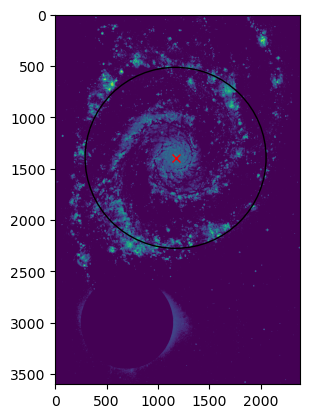

In [37]:
x0, y0 = M51_R_Table['x'], M51_R_Table['y']
print(x0,y0)
Re = (10**M51_R_Table['log_re'])
max_intensity = np.max(M51_R_Isolated)
fit_centre = (M51_R_Isolated.shape[1]/2+x0,M51_R_Isolated.shape[0]/2+y0)

R_e_circle = plt.Circle((fit_centre[0],fit_centre[1]),Re,fill=None)
fig, ax = plt.subplots()
ax.imshow(M51_R_Isolated)

ax.add_patch(R_e_circle)

# Need to compare fit center and intensity centre

intensity_centre = np.argmax(M51_R_Isolated)
#ax.plot(intensity_centre//M51_R_Isolated.shape[1],intensity_centre%M51_R_Isolated.shape[1],'rx')
print(intensity_centre)
ax.plot(fit_centre[0],fit_centre[1],'rx')
#ax.plot(1172,1394,'rx')
#ax.plot(intensity_centre//M51_R_Isolated.shape[1],intensity_centre%M51_R_Isolated.shape[1],'rx')



M51_R_Table

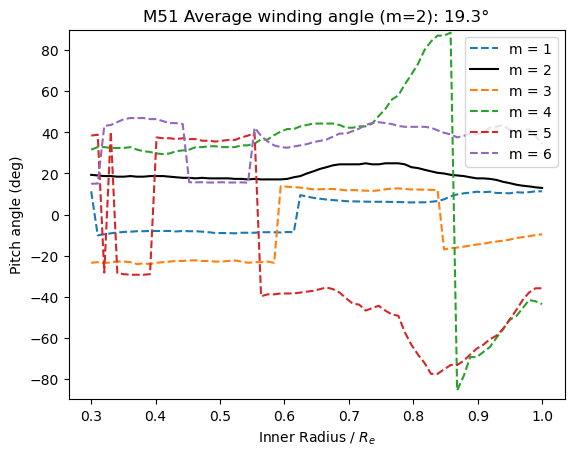

In [38]:
M_str_arr = np.array(['m = 1','m = 2','m = 3','m = 4','m = 5','m = 6'])
plt.figure()
plt.title('M51 Average winding angle (m=2): {}\u00B0'.format(np.around(np.mean(phi_array[:,1]),1)))
plt.ylabel('Pitch angle (deg)')
plt.xlabel('Inner Radius / $R_e$')
for i in range(0,len(m_array)):
    if i == 1:
        plt.plot(Inner_radii_multiples,phi_array[:,i],c='k')
    else:
        plt.plot(Inner_radii_multiples,phi_array[:,i],linestyle='--')
    
    
plt.ylim(-90,90)    
plt.legend(M_str_arr)

Inner_B = Inner_radii_multiples
phi_arr_B = phi_array

In [39]:
def plot_radial_pitch_angle_dependance(Candidate,phi_array,Inner_radii_multiples):
    """
    Plots the radial dependence of pitch angles for a given candidate.

    Parameters:
        Candidate (str): The name or identifier of the candidate for which the plot is being generated.
        phi_array (array): An array of pitch angles, where each element represents the pitch angle at a specific combination of inner radii multiple and dominant harmonic mode. The shape of phi_array is (len(Inner_radii_multiples), len(m_array)).
        Inner_radii_multiples (array): An array of inner radii multiples ranging from 0.3 to 1 with 70 equally spaced values.

    Returns:
        Plot: A plot showing the radial dependence of pitch angles for different harmonic modes, with the average winding angle for m=2 harmonic mode indicated in the plot title. The plot has pitch angle values on the y-axis, inner radii multiples on the x-axis, and different harmonic modes represented by different line styles/colors. The plot also includes a legend with labels for each harmonic mode. The y-axis is limited to a range of -90 to 90 degrees.
    """    
    M_str_arr = np.array(['m = 1','m = 2','m = 3','m = 4','m = 5','m = 6'])
    plt.figure()
    avg_pitch = np.around(np.mean(phi_array[:,1]),1)
    plt.title('{} Average winding angle (m=2): {}\u00B0'.format(Candidate,avg_pitch))
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Inner Radius / $R_e$')
    for i in range(0,len(m_array)):
        if i == 1:
            plt.plot(Inner_radii_multiples,phi_array[:,i],c='k')
        else:
            plt.plot(Inner_radii_multiples,phi_array[:,i],linestyle='--')
        
        
    plt.ylim(-90,90)    
    plt.legend(M_str_arr)

log_n,log_re,mag,q,theta,x,y
float64,float64,float64,float64,float64,float64,float64
-0.4826322137316846,2.9597991350336037,-27.032147122309713,0.732602422224486,-0.7135153088460121,-42.81309096310089,-380.2944152422871


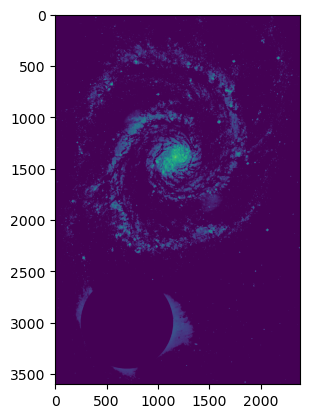

: 

In [44]:
plt.imshow(M51_G_Isolated)
M51_G_Table

In [40]:
Inner_B,phi_arr_B, relative_power_B = pitch_angle_against_radius(M51_B_Isolated,M51_B_Table)

In [41]:
Inner_G,phi_arr_G, relative_power_G = pitch_angle_against_radius(M51_G_Isolated,M51_G_Table)


KeyboardInterrupt: 

In [ ]:
Inner_R,phi_arr_R, relative_power_R = pitch_angle_against_radius(M51_R_Isolated,M51_R_Table)

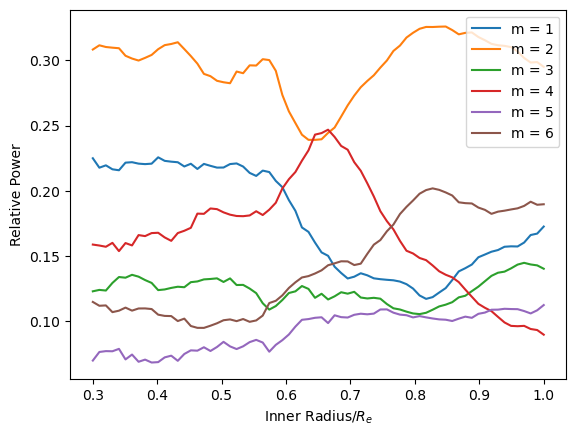

In [ ]:
# Need to plot the relative power

plt.figure()
plt.xlabel('Inner Radius/$R_e$')
plt.ylabel('Relative Power')
for i in range(0,relative_power_B.shape[1]):
    plt.plot(Inner_B,relative_power_B[:,i])
plt.legend(M_str_arr)

# Cool so want to make this into a subplots and
# add to Pich angle plot function


In [ ]:
def plot_pitch_angle_relative_power(Candidate,phi_array,Inner_radii_multiples,relative_power):
    M_str_arr = np.array(['m = 1','m = 2','m = 3','m = 4','m = 5','m = 6'])

    # create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # plot the first subplot
    avg_pitch = np.around(np.mean(phi_array[:,1]),1)
    fig.suptitle('{} Average winding angle (m=2): {}\u00B0'.format(Candidate,avg_pitch))
    axs[0].set_ylabel('Pitch angle (deg)')
    axs[0].set_xlabel('Inner Radius / $R_e$')
    for i in range(0,len(m_array)):
        if i == 1:
            axs[0].plot(Inner_radii_multiples,phi_array[:,i],c='k')
        else:
            axs[0].plot(Inner_radii_multiples,phi_array[:,i],linestyle='--')   
    axs[0].set_ylim(-90,90)    
    axs[0].legend(M_str_arr)

    # plot the second subplot
    axs[1].set_xlabel('Inner Radius/$R_e$')
    axs[1].set_ylabel('Relative Power')
    for i in range(0,relative_power_B.shape[1]):
        if i == 1:
            axs[1].plot(Inner_B,relative_power_B[:,i],c='k')
        else:
            axs[1].plot(Inner_B,relative_power_B[:,i],linestyle='--')
        
    axs[1].legend(M_str_arr)

    # adjust layout and spacing
    plt.tight_layout()


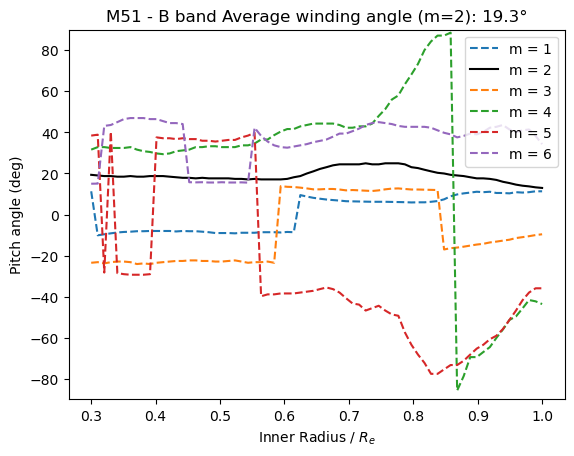

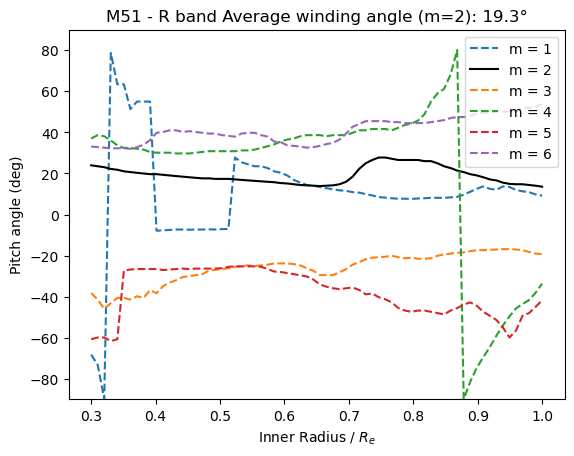

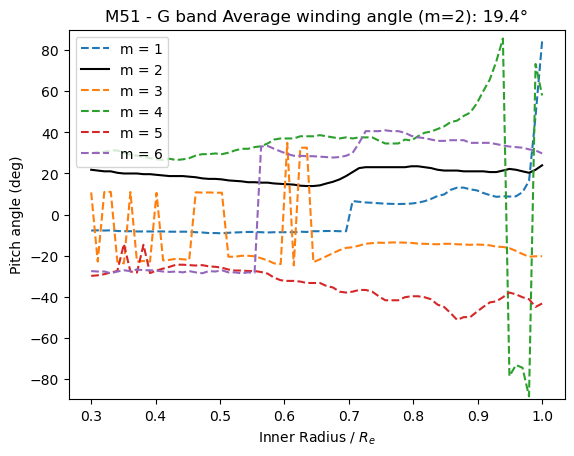

In [ ]:
plot_radial_pitch_angle_dependance('M51 - B band',phi_arr_B,Inner_B)
plot_radial_pitch_angle_dependance('M51 - R band',phi_arr_R,Inner_R)
plot_radial_pitch_angle_dependance('M51 - G band',phi_arr_G,Inner_G)

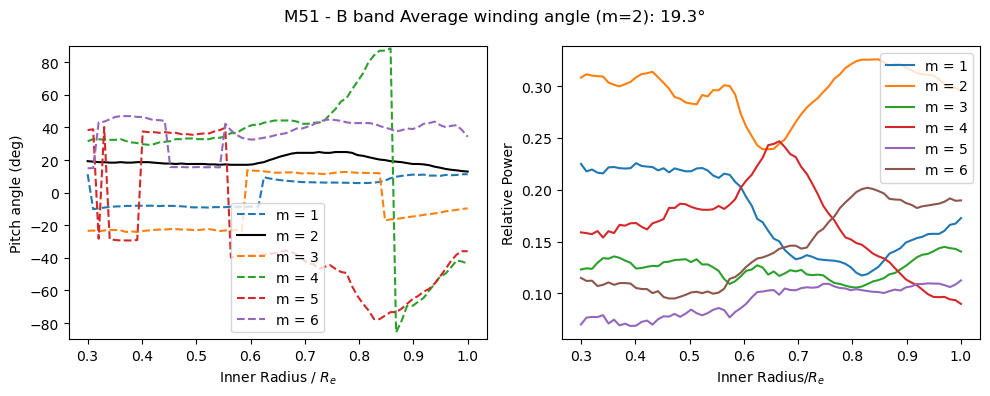

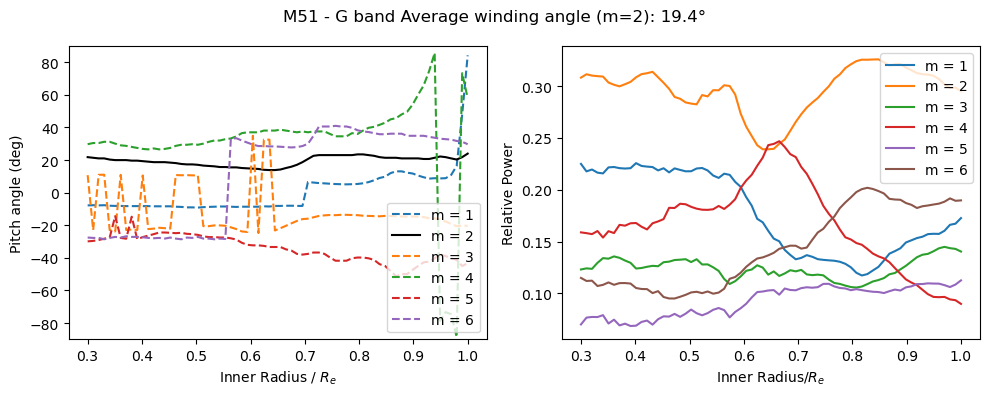

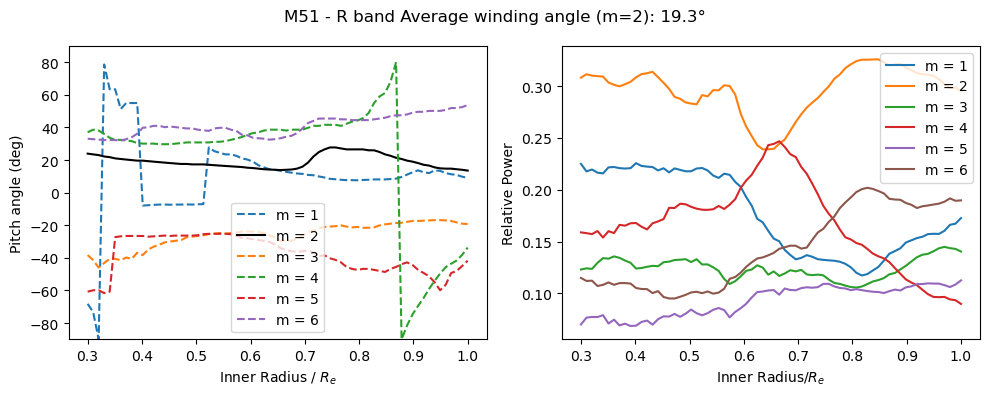

In [ ]:
plot_pitch_angle_relative_power('M51 - B band',phi_arr_B,Inner_B,relative_power_B)
plot_pitch_angle_relative_power('M51 - G band',phi_arr_G,Inner_G,relative_power_G)
plot_pitch_angle_relative_power('M51 - R band',phi_arr_R,Inner_R,relative_power_R)


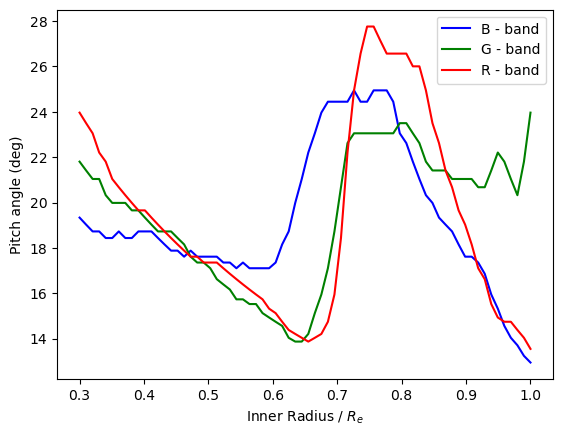

In [ ]:
# Wish to examine the wavelength dependence of winding angle with radius

# - G band something has gone wrong so will just compare B and R for now

plt.figure()
plt.ylabel('Pitch angle (deg)')
plt.xlabel('Inner Radius / $R_e$')
plt.plot(Inner_B,phi_arr_B[:,1],c='b')
plt.plot(Inner_B,phi_arr_G[:,1],c='g')
plt.plot(Inner_B,phi_arr_R[:,1],c='r')
plt.legend(['B - band','G - band','R - band'])


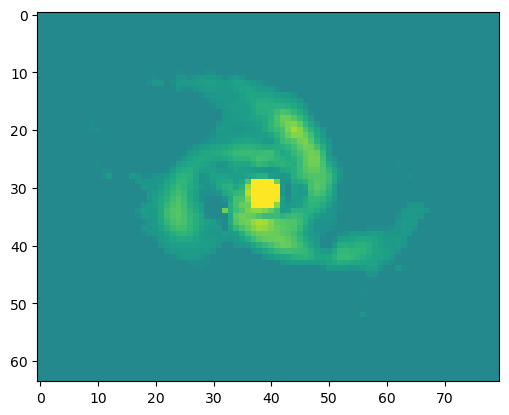

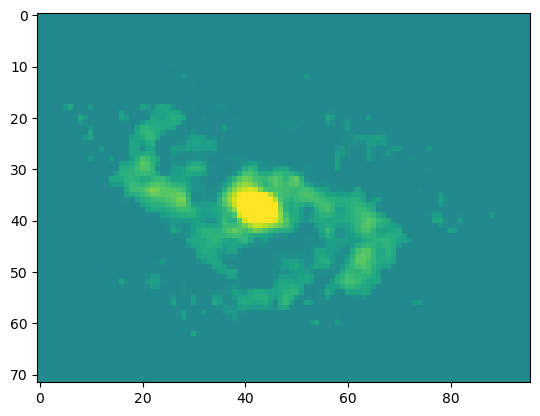

In [ ]:
# Checking if the MLIS1 run 22-04-23 is suitable

cand_6373 = gfits.Read('/home/borge/Data/MLIS1_Output/Is_the_filtering_wrong?/6373/0200/small_nonpar.fits')
cand_8208 = gfits.Read('/home/borge/Data/MLIS1_Output/Is_the_filtering_wrong?/8208/0188/small_nonpar.fits')

plt.figure()
plt.imshow(cand_6373,vmin=np.mean(cand_6373)-5*np.std(cand_6373),vmax=np.mean(cand_6373)+5*np.std(cand_6373))

plt.figure()
plt.imshow(cand_8208,vmin=np.mean(cand_8208)-5*np.std(cand_8208),vmax=np.mean(cand_8208)+5*np.std(cand_8208))

In [ ]:
hdul = fits.open('/home/borge/Data/Case_studies/M51/m51_optical_G.fits')
hdul.info()
fits_info = {}  # Initialize an empty dictionary
for key, value in hdul[0].header.items():
    print(key, "=", value)
    fits_info[key] = value
    

Filename: /home/borge/Data/Case_studies/M51/m51_optical_G.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (2384, 3600)   int16 (rescales to uint16)   
SIMPLE = True
BITPIX = 16
NAXIS = 2
NAXIS1 = 2384
NAXIS2 = 3600
EXTEND = True
COMMENT =   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT =   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
BZERO = 32768
BSCALE = 1
PROGRAM = PixInsight 01.08.03.1123
COMMENT = PixInsight Class Library: PCL 02.00.13.0692
COMMENT = FITS module version 01.01.02.0288
COLORSPC = Grayscale
RESOLUTN = 300.0
RESOUNIT = inch
DATE = 2014-05-15
ORIGIN = CXCs PinpointWCS
WCSAXES = 2.0
WCSNAME = Primary WCS
EQUINOX = 2000.0
RADESYS = ICRS
CTYPE1 = RA---TAN
CRPIX1 = 1192.0
CRVAL1 = 202.468285564118
CUNIT1 = deg
CTYPE2 = DEC--TAN
CRPIX2 = 1800.0
CRVAL2 = 47.2134616350831
CUNIT2 = deg
CD1_1 = -4.44552576533522e-05
CD1_2 = 2.59361057596344e-08
CD2_1 = 3.596032

In [ ]:
#The values of CD1_1, CD1_2, CD2_1, and CD2_2 in the header represent the coefficients of the linear transformation matrix,
# which can be used to determine the pixel scale along the X and Y axes.

CD1_1 = fits_info['CD1_1'] *3600 # Convert to arcseconds
CD2_2 = fits_info['CD2_2'] *3600

#CD1_1 - (-4.44552576533522e-05*3600)
CD2_2 - (4.44411209176657e-05*3600)


0.0

In [ ]:
# Need to convert the pixel scale along X and Y axis from arcseconds/pixel to kpc/pixel

Distance_to_M101 = 6.52e+3 # Kpc
Distance_to_M101_error = 0.12e+3 #Kpc

Distance_to_M51 = 8.58e+3 #Kpc
Distance_to_M51_error = 0.1e+3 # Kpc

R_e = float(10**M51_G_Table['log_re']) # Need to use the Green band - justification its the widest its the most centra and humans can see it best

# M51

x_arcsec_per_pixel = CD1_1 
y_arcsec_per_pixel = CD2_2 

def angular_arcsec_to_real(angular_size,distance):
    rad = angular_size*(4.84813681e-6)
    return 2*distance*np.tan(rad/2)

kpc_per_pixel_x = angular_arcsec_to_real(x_arcsec_per_pixel,Distance_to_M51)
kpc_per_pixel_y = angular_arcsec_to_real(y_arcsec_per_pixel,Distance_to_M51)



R_e_kpc_x = R_e*kpc_per_pixel_x
R_e_kpc_y = R_e*kpc_per_pixel_y

print(R_e_kpc_x,R_e_kpc_y)

R_e_kpc = np.sqrt((R_e_kpc_x**2) + (R_e_kpc_y**2))
R_e_kpc


# M101


-6.068577772282692 6.066647969499213


8.580900521744352

In [ ]:
R_e_kpc*0.7

6.006630365221047

In [ ]:
# Value in kpc - wjat value of effective radius is this?

# effective radius in kpc :
R_e_kpc

# Kpc as a multiple of R_e
one_kpc_in_R_e = 1/R_e_kpc

# So corotation would be:
corotation_merrifield = one_kpc_in_R_e*4.7
corotation_TW = one_kpc_in_R_e*5.3
ILR = one_kpc_in_R_e*((0.8+1.3)/2)
#corotation, ILR

one_kpc_in_R_e

0.1165378852098284

In [ ]:
# Want to create a function that will work out effective radius in Kpc from fits table and fits file
def R_e_in_KPC(fits_path,R_e_in_pixels,Distance_to_object):
    """
    Calculate the effective radius (R_e) of a galaxy in kiloparsecs (Kpc) based on its pixel size 
    in a FITS file, given the distance to the object in kiloparsecs.

    Parameters
    ----------
    fits_path : str
        File path to the FITS file.
    R_e_in_pixels : float or int
        Effective radius of the galaxy in pixels.
    Distance_to_object : float or int
        Distance to the galaxy in kiloparsecs.

    Returns
    -------
    R_e_kpc : float
        Effective radius of the galaxy in kiloparsecs.

    Notes
    -----
    - Distance_to_object must be in kiloparsecs.
    - The function opens the FITS file, retrieves header information, and calculates the 
      pixel-to-kiloparsec conversion factors based on the CD1_1 and CD2_2 header keywords.
    - The function then calculates the effective radius of the galaxy in kiloparsecs by multiplying 
      the pixel size (R_e_in_pixels) with the pixel-to-kiloparsec conversion factors 
      (kpc_per_pixel_x and kpc_per_pixel_y) and taking the square root of the sum of the 
      squares of these values.
    """
    # Distance to Object must be in Kpc!
    
    # Open Fits File
    hdul = fits.open(fits_path)
    
    fits_info = {}  # Create dictionary for header info
    for key, value in hdul[0].header.items():
        fits_info[key] = value
    
    # Retreive Pixel conversion factors
    CD1_1 = fits_info['CD1_1'] *3600 # Convert to arcseconds
    CD2_2 = fits_info['CD2_2'] *3600
    
    
    kpc_per_pixel_x = angular_arcsec_to_real(CD1_1,Distance_to_object) # Convert to real distance
    kpc_per_pixel_y = angular_arcsec_to_real(CD2_2,Distance_to_object)
    
    # Convert Pixel conversion to Re factors
    R_e_kpc_x = R_e_in_pixels*kpc_per_pixel_x
    R_e_kpc_y = R_e_in_pixels*kpc_per_pixel_y
    
    
    R_e_kpc = np.sqrt((R_e_kpc_x**2) + (R_e_kpc_y**2)) # Find radial Kpc value
    
    return R_e_kpc


R_e_in_KPC_test = R_e_in_KPC('/home/borge/Data/Case_studies/M51/m51_optical_G.fits',float(10**M51_G_Table['log_re']),Distance_to_M51)

R_e_kpc - R_e_in_KPC_test

0.0

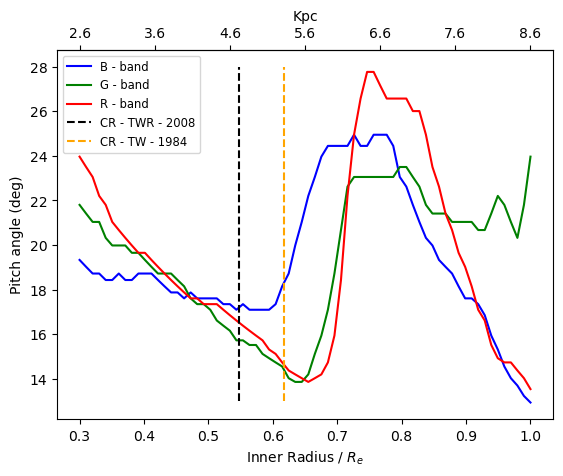

In [ ]:
x_ticks = np.linspace(0.3,1,7)
kpc_ticks = np.around(x_ticks*R_e_kpc,1)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data on the primary x-axis
ax.set_ylabel('Pitch angle (deg)')
ax.set_xlabel('Inner Radius / $R_e$')
ax.plot(Inner_B,phi_arr_B[:,1],c='b')
ax.plot(Inner_B,phi_arr_G[:,1],c='g')
ax.plot(Inner_B,phi_arr_R[:,1],c='r')
ax.vlines(corotation_merrifield,13,28,color='k',linestyle='--')
ax.vlines(corotation_TW,13,28,color='orange',linestyle='--')
ax.legend(['B - band','G - band','R - band','CR - TWR - 2008','CR - TW - 1984'],fontsize='small')

# Create a secondary x-axis at the top
ax2 = ax.secondary_xaxis('top')

# Set the labels and tick positions for the secondary x-axis
ax2.set_xlabel('Kpc')
ax2.set_xticks(x_ticks)  # Replace with your desired tick positions
ax2.set_xticklabels(kpc_ticks)  # Replace with your desired tick labels

plt.show()

In [ ]:
# Need to run CAS on M51

C_B_org,A_B_org,S_B_org = gfits.CAS(M51_B_Original,M51_B_Table)
C_B_iso,A_B_iso,S_B_iso = gfits.CAS(M51_B_Isolated,M51_B_Table)

C_G_org,A_G_org,S_G_org = gfits.CAS(M51_G_Original,M51_G_Table)
C_G_iso,A_G_iso,S_G_iso = gfits.CAS(M51_G_Isolated,M51_G_Table)

C_R_org,A_R_org,S_R_org = gfits.CAS(M51_R_Original,M51_R_Table)
C_R_iso,A_R_iso,S_R_iso = gfits.CAS(M51_R_Isolated,M51_R_Table)


In [ ]:
delta_C_B = np.abs(C_B_org-C_B_iso)
delta_A_B = np.abs(A_B_org-A_B_iso)
delta_S_B = np.abs(S_B_org-S_B_iso)

delta_C_G = np.abs(C_G_org-C_G_iso)
delta_A_G = np.abs(A_G_org-A_G_iso)
delta_S_G = np.abs(S_G_org-S_G_iso)

delta_C_R = np.abs(C_R_org-C_R_iso)
delta_A_R = np.abs(A_R_org-A_R_iso)
delta_S_R = np.abs(S_R_org-S_R_iso)

NameError: name 'C_B_org' is not defined

In [ ]:
print('CAS parameters for M51')
print('\n')
print('B - band')
print(C_B_org,A_B_org,S_B_org)

print(C_B_iso,A_B_iso,S_B_iso)
print('\n')
print('\n')
print('G - band')
print(C_G_org,A_G_org,S_G_org)

print(C_G_iso,A_G_iso,S_G_iso)
print('\n')
print('\n')
print('R - band')
print(C_R_org,A_R_org,S_R_org)

print(C_R_iso,A_R_iso,S_R_iso)
print('\n')
print('\n')
print('Delta CAS B band: ',delta_C_B,delta_A_B,delta_S_B)

print('Delta CAS G band: ',delta_C_G,delta_A_G,delta_S_G)

print('Delta CAS R band: ',delta_C_R,delta_A_R,delta_S_R)

CAS parameters for M51


B - band
4.870858598848897 0.5992619268299957 9.587756716680514e-06
4.421546433117829 1.5481115856110144 8.3531724647732e-05




G - band
4.658933610006092 0.6487537633802861 1.0473295323886828e-05
3.8542752035716745 1.4423824124021911 9.043957859323507e-05




R - band
4.84432330829502 0.8692868530002772 1.0615913013040321e-05
4.595333937849417 1.3957735077500695 7.39032329636245e-05




Delta CAS B band:  0.4493121657310679 0.9488496587810187 7.394396793105148e-05
Delta CAS G band:  0.8046584064344176 0.793628649021905 7.996628326934824e-05
Delta CAS R band:  0.248989370445603 0.5264866547497923 6.328731995058418e-05


In [ ]:
Final_1000_candidates = gfits.Read_Table('/home/borge/spiral_arms/Shivani/top_1000.fits')

In [ ]:
final_1000_candidate_list = np.asarray(Final_1000_candidates['OBJID']).astype(str)
identifiers = np.empty_like(final_1000_candidate_list)
for i in range(len(final_1000_candidate_list)):
    x = final_1000_candidate_list[i]
    identifiers[i] = x[-4:]
    
final_1000_candidate_list[:10]

array(['587722981742084144', '587734304879149235', '587734304338280673',
       '587734303267356871', '587733610158358702', '587733609630531886',
       '587733609093136687', '587733609089663067', '587733608016511091',
       '587733608015921346'], dtype='<U21')

In [ ]:
for i in range(0,10):
    exec('comp_{} = gfits.Read_M_band("{}","/home/borge/Data/Brightest_1000/Brightest_1000_Spirals/")'.format(identifiers[i],final_1000_candidate_list[i]),globals())
    exec('gfits.Composite_imshow(comp_{})'.format(identifiers[i]))

FileNotFoundError: [Errno 2] No such file or directory: '/home/borge/Data/Brightest_1000/Brightest_1000_Spirals/587722981742084144ua.fits.gz'

In [ ]:
# Define location
path = '/home/borge/Data/gz2and1master.fits.gz'
# Access file
data = gfits.Read_Table(path)

# create masks for extraction 
mask_gz1 = data['gz1_arms_clean'] == True
mask_gz2 = data['gz2_arms_clean'] == True
# combine masks
mask = mask_gz1 + mask_gz2
# apply mask to data
face_on_master_table = data[mask]

# get brightness
avg_mag = np.average([face_on_master_table['U'],face_on_master_table['G'],
            face_on_master_table['R'],face_on_master_table['I'],
            face_on_master_table['Z']],axis=0)

spirals = face_on_master_table['t04_spiral_a08_spiral_weighted_fraction']
bars = face_on_master_table['t03_bar_a06_bar_weighted_fraction']
z = face_on_master_table['REDSHIFT']    


In [ ]:
filtering_mask = ((spirals>0.8)&(bars<0.2)&(z<0.05)&(avg_mag<17.77))



In [ ]:
filtered_set = face_on_master_table[filtering_mask]

In [ ]:
sorted_filtered_set = filtered_set[np.argsort(avg_mag[filtering_mask])]


In [ ]:
sorted_filtered_set[:1000]

OBJID,OBJID_STR,RUN,RERUN,CAMCOL,FIELD,OBJ,RA,DEC,PETROR50_R,PETROR90_R,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,PETROMAGERR_I,PETROMAGERR_Z,PSFMAG_R,FIBERMAG_R,DEVMAG_R,DEVMAGERR_R,EXPMAG_R,EXPMAGERR_R,FRACDEV_R,MU50_R,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,ROWC_U,COLC_U,ROWC_G,COLC_G,ROWC_R,COLC_R,ROWC_I,COLC_I,ROWC_Z,COLC_Z,CMODELMAG_R,CMODELMAGERR_R,REDSHIFT,REDSHIFTERR,PETROMAG_MU,PETROMAG_MG,PETROMAG_MR,PETROMAG_MI,PETROMAG_MZ,PETROMAGERR_MU,PETROMAGERR_MG,PETROMAGERR_MR,PETROMAGERR_MI,PETROMAGERR_MZ,PETROR50_R_KPC,REGION,PETROR50_R_KPC_SIMPLE_BIN,PETROMAG_MR_SIMPLE_BIN,REDSHIFT_SIMPLE_BIN,WVT_BIN,sample,asset_id,total_count,total_weight,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_total_weight,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_total_weight,t03_bar_a06_bar_weight,t03_bar_a06_bar_weighted_fraction,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_weighted_fraction,t03_bar_total_weight,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_total_weight,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_total_weight,t06_odd_a14_yes_weight,t06_odd_a14_yes_weighted_fraction,t06_odd_a15_no_weight,t06_odd_a15_no_weighted_fraction,t06_odd_total_weight,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_weighted_fraction,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_weighted_fraction,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cigar_shaped_weighted_fraction,t07_rounded_total_weight,t08_odd_feature_a19_ring_weight,t08_odd_feature_a19_ring_weighted_fraction,t08_odd_feature_a20_lens_or_arc_weight,t08_odd_feature_a20_lens_or_arc_weighted_fraction,t08_odd_feature_a21_disturbed_weight,t08_odd_feature_a21_disturbed_weighted_fraction,t08_odd_feature_a22_irregular_weight,t08_odd_feature_a22_irregular_weighted_fraction,t08_odd_feature_a23_other_weight,t08_odd_feature_a23_other_weighted_fraction,t08_odd_feature_a24_merger_weight,t08_odd_feature_a24_merger_weighted_fraction,t08_odd_feature_a38_dust_lane_weight,t08_odd_feature_a38_dust_lane_weighted_fraction,t08_odd_feature_total_weight,t09_bulge_shape_a25_rounded_weight,t09_bulge_shape_a25_rounded_weighted_fraction,t09_bulge_shape_a26_boxy_weight,t09_bulge_shape_a26_boxy_weighted_fraction,t09_bulge_shape_a27_no_bulge_weight,t09_bulge_shape_a27_no_bulge_weighted_fraction,t09_bulge_shape_total_weight,t10_arms_winding_a28_tight_weight,t10_arms_winding_a28_tight_weighted_fraction,t10_arms_winding_a29_medium_weight,t10_arms_winding_a29_medium_weighted_fraction,t10_arms_winding_a30_loose_weight,t10_arms_winding_a30_loose_weighted_fraction,t10_arms_winding_total_weight,t11_arms_number_a31_1_weight,t11_arms_number_a31_1_weighted_fraction,t11_arms_number_a32_2_weight,t11_arms_number_a32_2_weighted_fraction,t11_arms_number_a33_3_weight,t11_arms_number_a33_3_weighted_fraction,t11_arms_number_a34_4_weight,t11_arms_number_a34_4_weighted_fraction,t11_arms_number_a36_more_than_4_weight,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_total_weight,U,G,R

In [ ]:
# Get candidate list from the sorted filtered set
Candidate_list = np.asarray(sorted_filtered_set['OBJID']).astype(str)
candidate_list = Candidate_list[:1000]

In [ ]:
with open('Final_1000_Spirals_filenames.txt', "w") as f:
    for s in candidate_list:
        f.write(s + "ua.fits.gz\n")
        f.write(s + "ga.fits.gz\n")
        f.write(s + "ra.fits.gz\n")
        f.write(s + "ia.fits.gz\n")
        f.write(s + "za.fits.gz\n")
